Absolving **Udacity's Data Analyst Nanodegree Programm**, I did the project **"Exploring Weather Data"**.
The project's goal is to create a visualization and to describe similarities and differences between global temperature and the temperature in Berlin, my home town.  
This document is submitted as a pdf, but can also be found on [github±±±±±]()

# Key **Findings**

## Key Visualization
![./pics/weather_data_berlin_vs_world.png](./pics/weather_data_berlin_vs_world.png)

## Key Conclusions

# **Outline** of the Project

## **Tools** Used and **Code**

### **SQL** Code Applied to **Extract Data** from Udacity's SQL Database
#### Basic Considerations
The instruction says that the local reference city shall be the "closest city" to where I live. As I live in Berlin, Germany, I first see in `city_list` which cities in Germany are included, before pulling the according weather data. Next, I pull the local weather data from `city_data` and the global weather data from `global_data` and join them together. Assuming, the provided data is clean (no duplicates, wrong types etc.) I skip the data cleansing part.

#### The Code
**Looking up cities in Germany**

```
SELECT *
    FROM city_list
    WHERE country='Germany'
```

It turns out, that Berlin (my hometown) is included in the list

**Retrieving Berlin Weather Data**

```
SELECT year, avg_temp AS berlin
    FROM city_data
    WHERE country='Germany' AND city='Berlin'
```

Note, that one can see that there are missing data right at the first years (174x).

**Retrieving Global Weather Data**

```
SELECT year, avg_temp AS global
    FROM global_data
```
Note, that one can see that the global data starts later than Berlins data (1750).

**Joining the Resulting Tables to One Table**

```
SELECT *
    FROM (
        SELECT year AS year, avg_temp AS berlin
            FROM city_data
            WHERE country='Germany' AND city='Berlin'
    ) AS my_city
    JOIN (
        SELECT year AS year, avg_temp AS world
            FROM global_data
        ) AS world
    ON my_city.year = world.year
```

This is the table, I actually **downloaded as CSV** (*results.csv*).

### **Python** Code to Join Data and **Calculate Moving Average**
#### Basic Considerations
I use the `pandas` library to import the data (and check it a bit for consistency).  
For calculating the moving average, I write a function returning a `pandas` `DataFrame`, which later allows me to investigate on different "moving windows". An explanation of the moving average can be found here: https://en.wikipedia.org/wiki/Moving_average.  
There also the general formula can be found:  


![moving average formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/d6a4be8da388bfd94fc368c98db6e8064ecd2746)
#### The Code

In [307]:
# Importing pandas as importing (and manipulation) tool for the csv
import pandas as pd

In [308]:
# Reading the csv "results.csv" (retrival described above)
raw_avg_temp = pd.read_csv("./data/results.csv")

In [309]:
# First look at the DataFrame
pd.concat([raw_avg_temp.head(3), raw_avg_temp.tail(3)])

,year,berlin,world
0,1750,9.83,8.72
1,1751,9.75,7.98
2,1752,4.84,5.78
261,2011,10.56,9.52
262,2012,9.96,9.51
263,2013,10.12,9.61


In [310]:
# Checking for duplicates (in years)
any(raw_avg_temp['year'].duplicated())

False

In [311]:
# As nothing is duplicated we set index to 'years'
avg_temp = raw_avg_temp.set_index(['year']).copy()

In [312]:
# Now looking at moving averages using pandas build-in 'rolling_mean' function
def moving_avg(df, window_size):
    return df.rolling(window_size).mean().dropna().copy()

With the Code above, we can return a generic rolling average with arbitrary window size. Let's give it a try with window size of 5.

In [313]:
moving_avg_temp = moving_avg(avg_temp, 5)
moving_avg_temp.head()

,berlin,world
year,,
1754,8.326,7.868
1755,8.012,7.796
1756,7.986,7.970
1757,8.848,8.618
1758,8.754,8.288


As expected, averaged temperaturs are being shown in 1754 (just five years after the "begin of records")

### **Python** Code to **Create Line Chart**
#### Basic Considerations
For visualizing the data, I choose the Altair library. This library comes in handy, as it "complies" with basic visualization principles ("grammar of visualization"). However, as Altair needs "normalized" tables, some further wrangling is necessary.
#### The Code

In [314]:
# Creating a normalized DataFrame (when all columns are to be stacked)
def create_normalized_df(df):
    return df.stack().reset_index().copy()

# Rename the columns
def rename_columns(df, col_names):
    df.columns = col_names
    return df

# Combining the above
def create_normalized_df_with_col_names(df, col_names):
    return rename_columns(create_normalized_df(df), col_names).copy()

# Function for this specific transformation (and creating datetime for 'year')
def create_moving_avg_temp(df, window_size):
    create_moving_avg_temp = create_normalized_df_with_col_names(moving_avg(df, window_size), ['year', 'level', 'avg_temp'])
    create_moving_avg_temp['year'] = pd.to_datetime(create_moving_avg_temp['year'], format='%Y')
    return create_moving_avg_temp

create_moving_avg_temp(avg_temp, 5).head()

,year,level,avg_temp
0,1754-01-01,berlin,8.326
1,1754-01-01,world,7.868
2,1755-01-01,berlin,8.012
3,1755-01-01,world,7.796
4,1756-01-01,berlin,7.986


In [315]:
import altair as alt

In [316]:
def avg_chart(moving_window):
    avg_chart = alt.Chart(create_moving_avg_temp(avg_temp, moving_window)).mark_line().encode(
        alt.X(
            'year:T', 
                title='Year'
        ),
        alt.Y(
            'avg_temp:Q', 
            title='Avg. Temp. [°C]', 
            scale=alt.Scale(zero=False)),
        alt.Color(
            'level:N'
        )
    ).properties(
        title='Avg. Temp. World vs. Berlin (Moving Window ' + str(moving_window) + ')'
    )
    return avg_chart

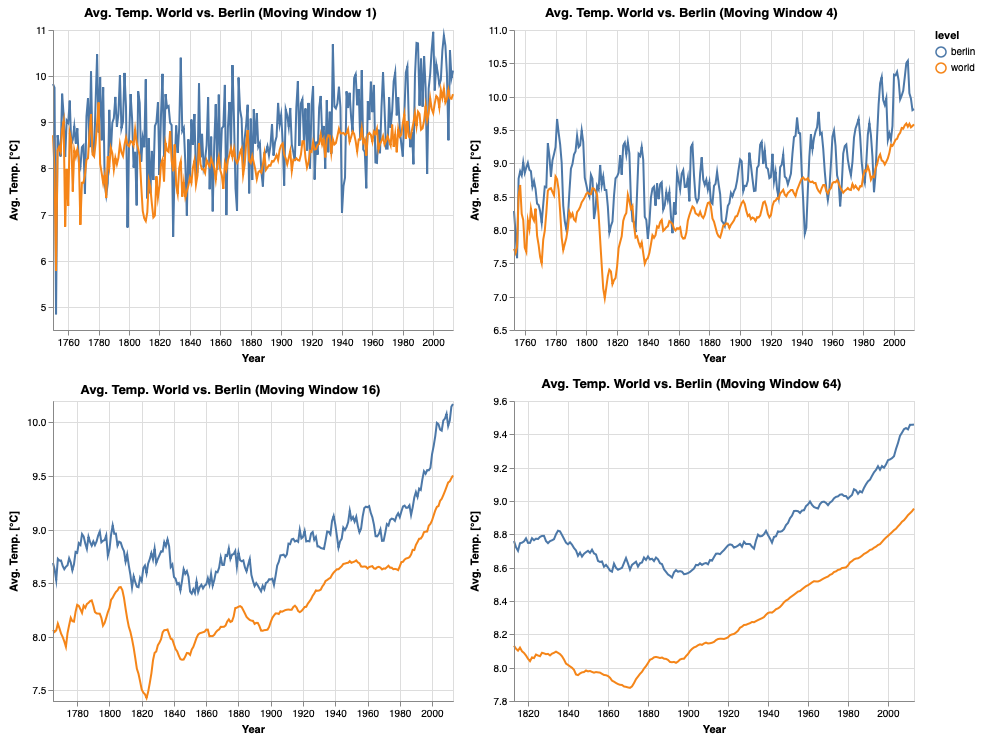

In [318]:
(avg_chart(1) | avg_chart(4)) & (avg_chart(16) | avg_chart(64))

When looking at the charts, it seems like a window size of approx. 16 would be good, as it "smoothens" the data enought, so that you can see the trends, but doesn't smear out too much (and isn't too much affected be the accounting for historical magnitude in actual magnitude).  
So, for the further Analysis I chose 16.

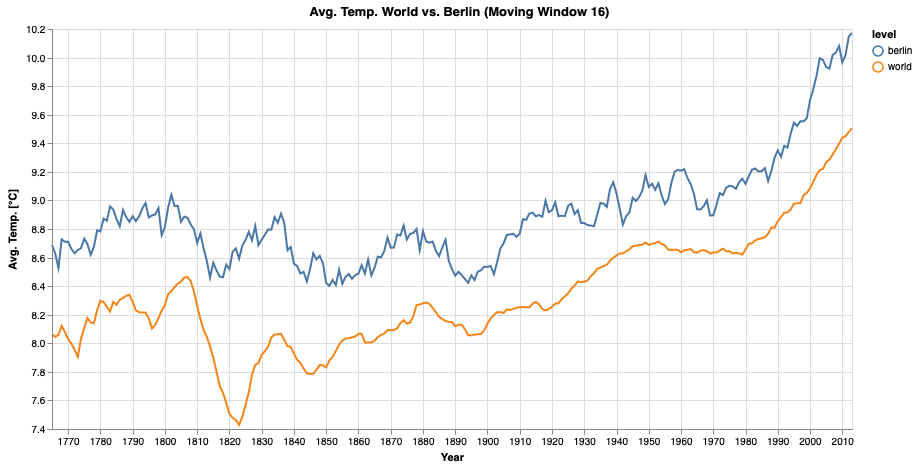

In [326]:
avg_chart(16).properties(width=800, height=400)

### **Analysis and Observations**

- What do we see?
 - Global highly fluctuating until ~1850 maybe due to measurement issues
 - Local temperatur stronger fluctuating as more "averaging out local effects on a global scale"
 - However global and local weather seem to be correlated
 - Temperature for both, local and global, having a stronger tendency to go up since ~1900 and even sharper since ~1970/80
 - Berlin approx. 0.5 °C warmer that global average (relatively consistent)
- Calculations
 - Correlations
 - Linear Regression (over different time scales)

# *Recap of Instructions from Udacity*

## The Steps According to Instructions from Udacity
The goal is to create a visualization and to describe the similarities and differences between global temperature trends and temperature trends in Berlin, Germany (and other places on earth). 

To do this, I followed the steps below:

- **Extract the data** from the database. In Udacity, there's a workspace that is connected to a database. I exported the temperature data for the world as well as for Berlin, the city where I live.
 - I wrote a SQL query to extract the city level data for Berlin and exported it to CSV. 
 - I wrote a SQL query to extract the global data and exported it to CSV.
- **Open up the CSV** in Python (within a Jupyter Notebook in JupyterLab).

- **Create a line chart** that compares Berlin's temperatures with the global temperatures. I made sure to plot the ***moving average*** rather than the yearly averages in order to smooth out the lines, making trends more observable (the last concept in the previous lesson goes over how to do this in a spreadsheet).
- **Make observations** about the similarities and differences between the world averages and Berlins averages, as well as overall trends. Here are some questions I started with.
 - Is your Berlin hotter or cooler on average compared to the global average? Has the difference been consistent over time?
 - “How do the changes in Berlin's temperatures over time compare to the changes in the global average?”
 - What does the overall trend look like? Is the world getting hotter or cooler? Has the trend been consistent over the last few hundred years?

## Submission
My submission to Udacity is a PDF from this Notebook that includes:

- **An outline** of steps taken to prepare the data to be visualized in the chart, such as:
 - What tools did I use for each step? (Python, SQL, Excel, etc)
 - How did I calculate the moving average?
 - What were my key considerations when deciding how to visualize the trends?
- **Line chart** with local and global temperature trends
- At least **four observations** about the similarities and/or differences in the trends

I order to meet the Udacity reviewer's expectations I followed the following **rubric** as a self-assessment before submission.

- Student is able to extract data from a database using SQL.
 - The SQL query used to extract the data is included.
 - The query runs without error and pulls the intended data.


- Student is able to manipulate data in a spreadsheet or similar tool.
 - Moving averages are calculated to be used in the line chart.
 - Student is able to create a clear data visualization.


- A line chart is included in the submission.
 - The chart and its axes have titles, and there's a clear legend (if applicable).
 - Student is able to interpret a data visualization.


- The student includes four observations about their provided data visualization.
 - The four observations are accurate.